<a href="https://colab.research.google.com/github/Ajwad07/ML_projects_/blob/main/Linear_DAE_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch.utils.data
from torchvision import datasets,transforms
import numpy as np
import pandas as pd
from torch import nn,optim

In [2]:
from torch.utils.data import DataLoader

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0,1)
])

In [20]:
train_set=datasets.MNIST(root='./data',
                         train=True,
                         download=True,
                         transform=transform)
test_set=datasets.MNIST(root='./data',
                        train=False,
                        download=True,
                        transform=transform)

In [21]:
batch_size=128
train_loader=DataLoader(train_set,
                        batch_size=batch_size,
                        shuffle=True)
test_loader=DataLoader(test_set,
                       batch_size=batch_size,
                       shuffle=True)

In [22]:
class DAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28*1,512)
        self.fc2=nn.Linear(512,256)
        self.fc3=nn.Linear(256,128)

        self.fc4=nn.Linear(128,256)
        self.fc5=nn.Linear(256,512)
        self.fc6=nn.Linear(512,28*28*1)


        self.relu=nn.ReLU()
        self.sigmoid=nn.Sigmoid()

    def encoder(self,x):
        x=self.relu(self.fc1(x))
        x=self.relu(self.fc2(x))
        x=self.relu(self.fc3(x))
        return x
    def decoder(self,x):
        x=self.relu(self.fc4(x))
        x=self.relu(self.fc5(x))
        x=self.sigmoid(self.fc6(x))
        return x

    def forward(self,x):
      q=self.encoder(x.view(-1,784))
      return self.decoder(q)

In [30]:
epochs=20
model=DAE().to(device)
optimizer=optim.Adam(model.parameters(),lr=0.001)
loss_fn=nn.MSELoss()

In [31]:
def train(epoch, model, train_loader, optimizer, loss_fn, cuda=True):
    model.train()
    train_loss = []

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        # Add noise to the input
        noise = torch.randn_like(data)
        data_noisy = data + noise

        # Forward pass
        output = model(data_noisy)
        loss = loss_fn(output, data.view(data.size(0), -1))
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())  # Store the loss value

        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                  f"({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

    # Compute the correct average
    avg_loss = sum(train_loss) / len(train_loss)
    print(f"====> Epoch: {epoch} Average loss: {avg_loss:.4f}")
    return avg_loss


In [32]:
for epoch in range(1,epochs+1):
  train(epoch,model,train_loader,optimizer,loss_fn,True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.231689
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.063598
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.059769
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.048895
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.042985
====> Epoch: 1 Average loss: 0.0586
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.042943
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.040954
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.038036
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.037804
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.035316
====> Epoch: 2 Average loss: 0.0378
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.037331
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.036195
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.034663
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.033933
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.031859
====> Epoch: 3 Average loss: 0.0332
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.030822
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.028959
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.030794
Train Epoch:

In [33]:
import matplotlib.pyplot as plt

def show_reconstruction(model, data_loader, num_images=10):
    model.eval()
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            data_noise = torch.randn_like(data)
            noisy = data + data_noise
            reconstructed = model(noisy)

            data = data.cpu()
            noisy = noisy.cpu()
            reconstructed = reconstructed.cpu().view(data.size())  # reshape if needed

            for i in range(num_images):
                fig, axs = plt.subplots(1, 3, figsize=(9, 3))
                axs[0].imshow(data[i].squeeze(), cmap='gray')
                axs[0].set_title("Original")
                axs[1].imshow(noisy[i].squeeze(), cmap='gray')
                axs[1].set_title("Noisy")
                axs[2].imshow(reconstructed[i].squeeze(), cmap='gray')
                axs[2].set_title("Reconstructed")
                for ax in axs:
                    ax.axis('off')
                plt.show()
            break  # Only one batch


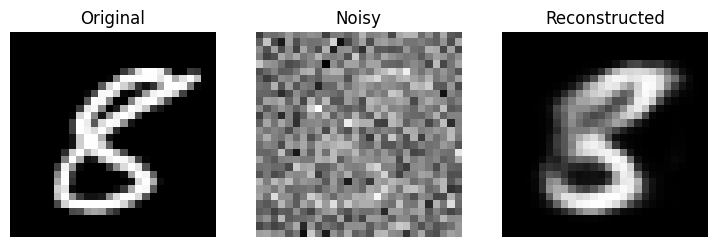

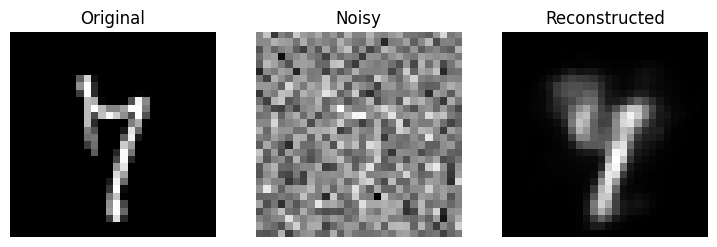

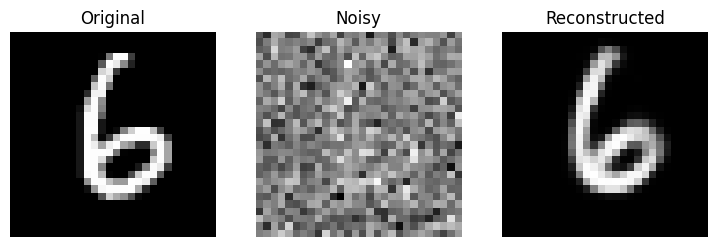

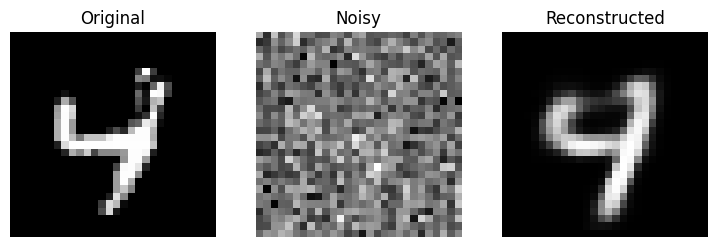

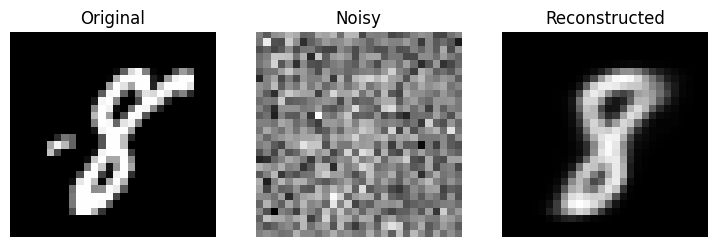

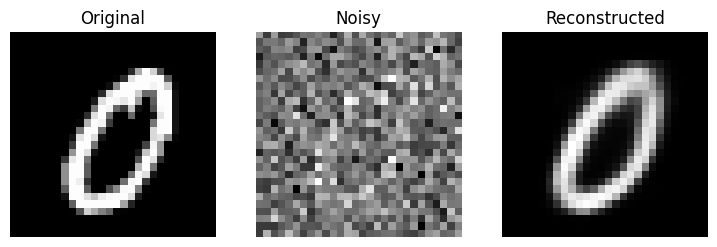

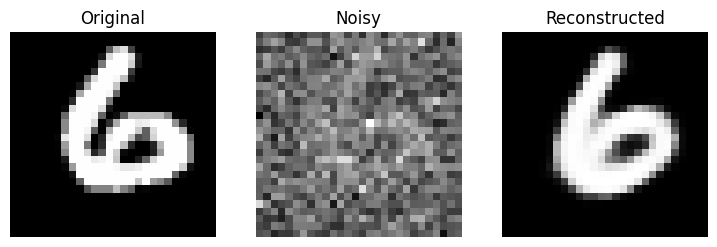

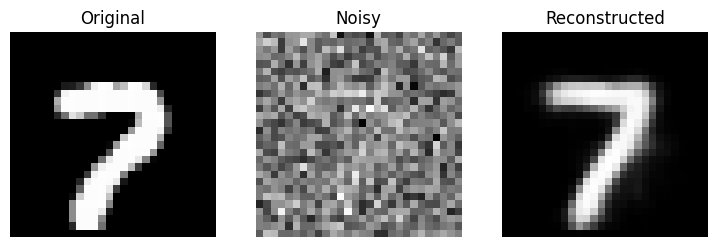

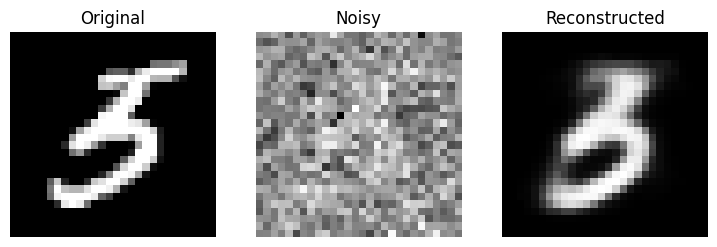

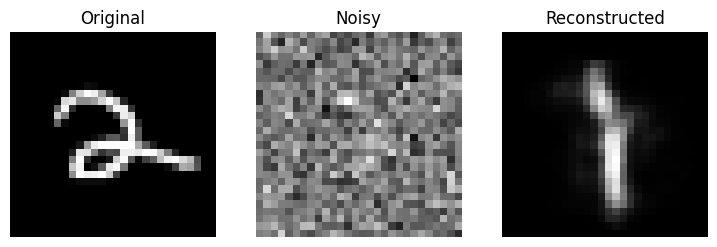

In [34]:
show_reconstruction(model, test_loader)
